In [32]:
import functools
import itertools
import pathlib
from typing import Iterable, Union

import bioframe as bf
import hg
import ipywidgets
import jscatter
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import traitlets
import traittypes
from IPython.display import display

data_dir = pathlib.Path.cwd() / "data"

## Linked embeddings of single-locus interaction profiles

In [53]:
def load_eigs(stages: tuple[str, ...]) -> list[pd.DataFrame]:
    eigs = []
    for name in stages:
        eigs_path = (
            data_dir
            / f"eigvecs.proj__ESC-Trypsin-FA-DSG-HindIII.{name}-Trypsin-FA-DSG-HindIII.E1-E10.hg38.50000.pq"
        )
        eigs_df = pd.read_parquet(eigs_path).dropna()
        eigs.append(eigs_df)

    # create shared index for all dataframes
    index = functools.reduce(pd.Index.intersection, [df.index for df in eigs])
    return [df.loc[index] for df in eigs]

def load_track_metadata() -> tuple[pd.DataFrame, dict[str, dict]]:
    tracks = pd.read_parquet(data_dir / "tracks.hg38.50000.pq")
    clusters = pd.read_parquet(
        data_dir
        / "clusters.joint.proj__ESC-Trypsin-FA-DSG-HindIII.E1-E10.50000.kmeans_sm.pq"
    ).filter(regex="^kmeans_sm\d+$")
    for col in clusters:
        clusters[col] = clusters[col].astype(str)
    return tracks.join(clusters), {
        "GC": dict(norm=colors.Normalize(vmin=0.35, vmax=0.65), map="RdYlBu_r"),
        "centel_abs": dict(norm=colors.Normalize(vmin=0, vmax=149043529), map="Greys"),
        "kmeans_sm8": dict(
            relabel={ "7": "A1", "5": "A2", "6": "AB", "4": "A3", "3": "A3", "1": "B0", "0": "B0", "2": "B4", "8": np.nan },
            map={'A1': '#e23838', 'A2': '#f78200', 'AB': '#5ebd3e', 'A3': '#ffb900', 'B0': 'cornflowerblue', 'B4': '#973999'}
        )
    }

def init_dropdowns(
    x: str,
    y: str,
    color: str,
    scatters: Iterable[jscatter.Scatter],
):
    tracks, color_config = load_track_metadata()
    xy_options = [f"E{i}" for i in range(1, 11)]    
    color_options = [c for c in tracks.columns if c not in ["start", "end"]]
    color_options.remove(color)
    color_options.insert(0, color)

    x_dropdown = ipywidgets.Dropdown(options=xy_options, value=x, description="x:")

    def on_change_x(change):
        for scatter in scatters:
            scatter.x(change.new)

    y_dropdown = ipywidgets.Dropdown(options=xy_options, value=y, description="y:")

    def on_change_y(change):
        for scatter in scatters:
            scatter.y(change.new)

    c_dropdown = ipywidgets.Dropdown(
        options=color_options, value=color, description="color:"
    )
    
    def extract_color_series(
        track_data: pd.DataFrame,
        field: str,
        color_kwargs: Union[dict, None],
    ):
        data = track_data[field]
        if color_kwargs is None:
            color_kwargs = {}
            if data.dtype.name in ("object", "category"):
                data = data.astype("category") # ensure categorical
                color_kwargs["map"] = dict(zip(data.cat.categories, jscatter.glasbey_dark))
            else:
                color_kwargs["norm"] = colors.Normalize(vmin=data.min(), vmax=data.max())
                color_kwargs["map"] = "viridis_r"
            return data, color_kwargs
        if color_kwargs and "relabel" in color_kwargs:
            data = data.map(color_kwargs["relabel"])
                        
        return data, color_kwargs

    def on_change_color(change):
        field = change["new"]
        for scatter in scatters:
            track_data = tracks.loc[scatter._data.index]
            data, kwargs = extract_color_series(track_data, field, color_config.get(field))
            scatter._data["_color"] = data
            scatter.color(by="_color", **kwargs)

    x_dropdown.observe(on_change_x, names=["value"])
    y_dropdown.observe(on_change_y, names=["value"])
    c_dropdown.observe(on_change_color, names=["value"])
    on_change_color(dict(new=color))

    return x_dropdown, y_dropdown, c_dropdown

def init_scatters(
    stages: tuple[str, ...] = ("ESC", "DE", "HB", "iHEP", "mHEP"),
    x: str = "E1",
    y: str = "E2",
    color: str = "kmeans_sm8",
):
    eigs = load_eigs(stages=stages)
    scatters = [jscatter.Scatter(x=x, y=y, data=data, opacity=0.5) for data in eigs]
    src = scatters[0]
    for target in scatters[1:]:
        ipywidgets.jslink((src.widget, "selection"), (target.widget, "selection"))
    
    dropdowns = init_dropdowns(x=x, y=y, color=color, scatters=scatters)
    
    component = ipywidgets.VBox([
        ipywidgets.HBox([
            ipywidgets.VBox([ipywidgets.Label(name), s.show()])
            for name, s in zip(stages, scatters)
        ]),
        ipywidgets.HBox(dropdowns)
    ])
    
    # we expose a single "selection" for this component, which the viewer can subscribe to
    component.add_traits(selection=traittypes.Array([]))
    
    ipywidgets.dlink(
        source=(scatters[0].widget, "selection"),
        target=(component, "selection"),
        transform=lambda ind: scatters[0]._data.iloc[ind]
    )
    
    return component

scatter = init_scatters()
scatter

## Linked RNA seq violinplot

Output()

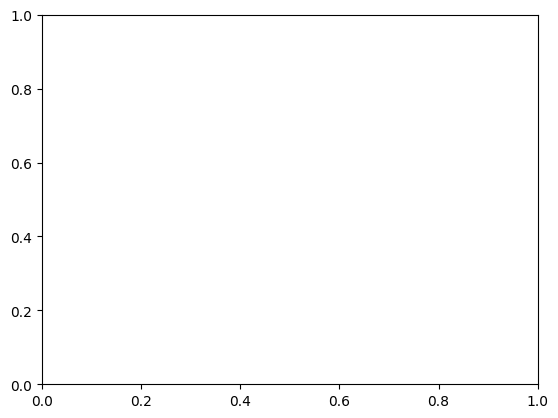

In [39]:
def init_violinplot(scatter):
    rna = pd.read_parquet(data_dir / "tracks.hg38.50000.pq").filter(regex="R1.fwd$")
    fig, ax = plt.figure(), plt.subplot(111)
    output = ipywidgets.Output()

    def on_selection_change(change):
        try:
            ax.clear()
            data = np.log10(rna.loc[change.new.index] + 1).melt()
            sns.violinplot(x="variable", y="value", data=data, ax=ax)
            output.clear_output()
            with output:
                display(fig)
        except Exception as e:
            with output:
                print(e)

    scatter.observe(on_selection_change, names=["selection"])
    return output

violinplot = init_violinplot(scatter)
violinplot

In [37]:
def init_viewer(scatter: traitlets.HasTraits):
    conf = hg.Viewconf.parse_file("./viewconf.json")
    clusters = bf.read_table(data_dir / "clusters.proj__all.JOINT.50000.E1-E10.kmeans_sm8.bed")
    # return conf.widget()
    return clusters

init_viewer(None)

,0,1,2,3,4,5,6,7,8
0,chr1,1100000,1200000,A1,.,.,1100000,1200000,"226,56,56"
1,chr1,1550000,1600000,A1,.,.,1550000,1600000,"226,56,56"
2,chr1,1900000,2450000,A1,.,.,1900000,2450000,"226,56,56"
3,chr1,2500000,2600000,A1,.,.,2500000,2600000,"226,56,56"
4,chr1,2600000,2650000,AB,.,.,2600000,2650000,"94,189,62"
...,...,...,...,...,...,...,...,...,...
8123,chr9,137400000,137450000,A1,.,.,137400000,137450000,"226,56,56"
8124,chr9,137550000,137900000,A1,.,.,137550000,137900000,"226,56,56"
8125,chr9,137900000,137950000,AB,.,.,137900000,137950000,"94,189,62"
8126,chr9,137950000,138000000,A1,.,.,137950000,138000000,"226,56,56"


In [28]:
ipywidgets.VBox([
    w,
    scatter
])

In [40]:
bioframe

In [47]:
data = load_track_metadata()[0]

,chrom,start,end,GC,arm,armlen,centel,centel_abs,H1.ESC.H3K9me3,H1.ESC.CBX5,...,kmeans_sm8,kmeans_sm9,kmeans_sm10,kmeans_sm11,kmeans_sm12,kmeans_sm14,kmeans_sm16,kmeans_sm24,kmeans_sm32,kmeans_sm64
0,chr1,0,50000,0.484250,chr1p,123500000,0.999595,123450000,0.027955,0.022146,...,8,9,10,11,12,14,16,24,32,64
1,chr1,50000,100000,0.376740,chr1p,123500000,0.999190,123400000,0.037727,0.061554,...,8,9,10,11,12,14,16,24,32,64
2,chr1,100000,150000,0.429960,chr1p,123500000,0.998785,123350000,0.036783,0.045140,...,8,9,10,11,12,14,16,24,32,64
3,chr1,150000,200000,0.486340,chr1p,123500000,0.998381,123300000,0.436818,0.107568,...,8,9,10,11,12,14,16,24,32,64
4,chr1,200000,250000,0.480564,chr1p,123500000,0.997976,123250000,0.000000,0.004104,...,8,9,10,11,12,14,16,24,32,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57504,chr22,50600000,50650000,0.528300,chr22q,36818468,0.995424,36650000,0.675729,0.766097,...,7,8,9,10,11,13,15,23,31,63
57505,chr22,50650000,50700000,0.514480,chr22q,36818468,0.996782,36700000,0.984272,0.845575,...,7,8,9,10,11,13,15,23,31,63
57506,chr22,50700000,50750000,0.566380,chr22q,36818468,0.998140,36750000,0.430886,0.719854,...,7,8,9,10,11,13,15,23,31,63
57507,chr22,50750000,50800000,0.441900,chr22q,36818468,0.999498,36800000,0.180044,0.230912,...,8,9,10,11,12,14,16,24,32,64


In [51]:
data.columns

Index(['chrom', 'start', 'end', 'GC', 'arm', 'armlen', 'centel', 'centel_abs',
       'H1.ESC.H3K9me3', 'H1.ESC.CBX5',
       ...
       'kmeans_sm8', 'kmeans_sm9', 'kmeans_sm10', 'kmeans_sm11', 'kmeans_sm12',
       'kmeans_sm14', 'kmeans_sm16', 'kmeans_sm24', 'kmeans_sm32',
       'kmeans_sm64'],
      dtype='object', length=137)